In [24]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import wandb

In [25]:
# Example values for the probabilities
x = torch.tensor([[9/25,12/25,4/25],[2.,1/4,1/5]],requires_grad=True)
y = torch.tensor([[1/3,1/3,1/3],[2.,5/4,1/5]])
print(x)
print(y)

tensor([[0.3600, 0.4800, 0.1600],
        [2.0000, 0.2500, 0.2000]], requires_grad=True)
tensor([[0.3333, 0.3333, 0.3333],
        [2.0000, 1.2500, 0.2000]])


In [26]:
# Example of divergence being infinity
#x = torch.tensor([[-0.7753, -0.7236, -0.6072, -0.8284, -0.8085, -0.8923, -0.6853, -0.8315,-0.8302, -0.7934]])
#y = torch.tensor([[-9.7151e+00, -7.6585e+00, -7.3228e+00, -7.9473e-08, -1.0569e+01,-6.7095e+00, -1.1969e+01, -7.1102e+00, -5.1660e+00, -6.2902e+00]])
#print(x)
#print(y)

In [27]:
# Definition of Renyi Divergence with logits as input
class RenyiDivergence(nn.Module):
    def __init__(self, alpha=0.5):
        super(RenyiDivergence, self).__init__()
        self.alpha = alpha

    def forward(self, logits_p, logits_q):
        if self.alpha == 1.0: # KL Divergence
            log_sums = torch.logsumexp(logits_q, dim=1)-torch.logsumexp(logits_p, dim=1)
            
            exp_logits_p = torch.exp(logits_p)
            sum_exp_p = exp_logits_p.sum(dim=1, keepdim=True)
            
            loss = torch.sum((exp_logits_p / sum_exp_p) * (logits_p - logits_q + log_sums.unsqueeze(1)), dim=1)
            
            return loss.mean()
        
        exp_p = torch.exp(logits_p)
        exp_q = torch.exp(logits_q)
        
        power_p = exp_p.pow(self.alpha)
        power_q = exp_q.pow(1-self.alpha)
        
        sum_exp_p = torch.sum(exp_p,dim=1)
        sum_exp_q = torch.sum(exp_q,dim=1)
        
        loss = 1/(self.alpha-1) * (torch.log(torch.sum(power_p*power_q,dim=1)) - self.alpha*torch.log(sum_exp_p) + (self.alpha-1)*torch.log(sum_exp_q))
        
        return loss.mean()

In [28]:
# Test
output = RenyiDivergence(alpha=10)(x,y)
print(output)
output.backward()

tensor(0.1249, grad_fn=<MeanBackward0>)


In [29]:
## Preparation for plot creation
Q = torch.tensor([[1/3,2/3]])
Q = torch.log(Q)
lists = []
for alpha in [0.5,1,2,10]:
    list = []
    for p in range(501):
        P = torch.tensor([[p/500,1-p/500]])
        P = torch.log(P)
        divergence = RenyiDivergence(alpha=alpha)(P,Q)
        list.append(divergence)
    lists.append(list)
    
for p in range(501):
    list = []
    P = torch.tensor([[p/500,1-p/500]])

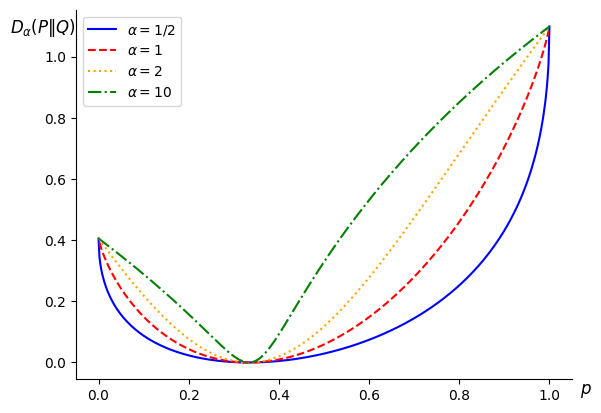

In [30]:
## Ploting
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()


ax.plot(np.array(range(501)) / 500, np.transpose(np.array(lists[0])), color='blue', linestyle='-', label=r'$\alpha = 1/2$')
ax.plot(np.array(range(501)) / 500, np.transpose(np.array(lists[1])), color='red', linestyle='--', label=r'$\alpha = 1$')
ax.plot(np.array(range(501)) / 500, np.transpose(np.array(lists[2])), color='orange', linestyle=':', label=r'$\alpha = 2$')
ax.plot(np.array(range(501)) / 500, np.transpose(np.array(lists[3])), color='green', linestyle='-.', label=r'$\alpha = 10$')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.annotate(r'$p$', xy=(1.05, 0), xytext=(10, -20), 
            textcoords='offset points', ha='center', va='center', fontsize=12)

ax.annotate(r'$D_\alpha(P \| Q)$', xy=(0, 1.05), xytext=(-40, 10), 
            textcoords='offset points', ha='center', va='center', fontsize=12)

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')


ax.legend()

fig.savefig('Renyi_Divergence.png')

plt.show()

In [86]:
# Define transforms for the training and test sets
transform = transforms.Compose([
    transforms.Resize((14, 14)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the datasets
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [0.95,0.05], generator=torch.Generator().manual_seed(872))

# Create DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, generator=torch.Generator().manual_seed(872))
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True, generator=torch.Generator().manual_seed(872))
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [101]:
class TeacherNetwork(nn.Module):
    def __init__(self):
        super(TeacherNetwork, self).__init__()
        self.fc1 = nn.Linear(14*14, 128) 
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.dropout_input = 0.1
        self.dropout_hidden = 0.3
        self.is_training = True

    def forward(self, x):
        x = x.view(-1, 14*14)  # Flatten the image
        x = F.dropout(x, p=self.dropout_input, training=self.is_training)
        x = F.dropout(F.relu(self.fc1(x)), p=self.dropout_hidden, training=self.is_training)
        x = F.dropout(F.relu(self.fc2(x)), p=self.dropout_hidden, training=self.is_training)
        x = self.fc3(x)
        return x

In [117]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
teacher_model = TeacherNetwork().to(device)
optimizer = optim.SGD(teacher_model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
num_epochs = 10

wandb.init(
    project="Renyi_Divergence_MNIST",
    name = "Teacher Model",
    config={}
)

print("Starting training...")

for epoch in range(num_epochs):
    print(f'---Epoch {epoch+1}---')
    
    train_loss, train_accuracy, size = 0, 0, 0
    for i, (data, targets) in enumerate(train_loader):
        data, targets = data.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = teacher_model(data)
        loss = nn.CrossEntropyLoss()(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * targets.size(0)
        train_accuracy += torch.sum(torch.argmax(outputs, dim=1) == targets).item()
        size += targets.size(0)
        
    train_loss = train_loss/size
    train_accuracy = train_accuracy/size
    
    print(f'Average Train Loss: {train_loss:.4f} \t \t Train Accuracy: {100*train_accuracy:.2f}%')
    
    teacher_model.is_training = False
    
    val_loss, val_accuracy, size = 0, 0, 0
    for i, (data, targets) in enumerate(val_loader):
        data, targets = data.to(device), targets.to(device)
        with torch.no_grad():
            pred = teacher_model(data)
            val_loss += nn.CrossEntropyLoss()(pred, targets) * targets.shape[0]
            val_accuracy += torch.sum(torch.argmax(pred, dim=1) == targets).item()
        size += targets.shape[0]
    
    val_loss, val_accuracy = val_loss / size, val_accuracy / size
    
    print(f'Average Validation Loss: {val_loss:.4f} \t Validation Accuracy: {100*val_accuracy:.2f}%')
    
    wandb.log({"train_loss": train_loss,
               "val_loss": val_loss,
               "train_accuracy": 100*train_accuracy,
               "val_accuracy": 100*val_accuracy,
               "epoch": epoch
               }
    )
    
    teacher_model.is_training = True

teacher_model.is_training = False
test_loss, test_accuracy, size = 0, 0, 0

for i, (data, targets) in enumerate(test_loader):
        data, targets = data.to(device), targets.to(device)
        with torch.no_grad():
            pred = teacher_model(data)
            test_loss += nn.CrossEntropyLoss()(pred, targets) * targets.shape[0]
            test_accuracy += torch.sum(torch.argmax(pred, dim=1) == targets).item()
        size += targets.shape[0]

test_loss, test_accuracy = test_loss / size, test_accuracy / size

print(f'Training finished.')
print(f'Average Validation Loss: {test_loss:.4f}\t Validation Accuracy: {100*test_accuracy:.2f}%')

wandb.finish()

Starting training...
---Epoch 1---
Average Train Loss: 0.8255 	 	 Train Accuracy: 72.87%
Average Validation Loss: 0.3041 	 Validation Accuracy: 90.23%
---Epoch 2---
Average Train Loss: 0.4372 	 	 Train Accuracy: 86.59%
Average Validation Loss: 0.2307 	 Validation Accuracy: 93.20%
---Epoch 3---
Average Train Loss: 0.3666 	 	 Train Accuracy: 88.79%
Average Validation Loss: 0.1856 	 Validation Accuracy: 94.30%
---Epoch 4---
Average Train Loss: 0.3283 	 	 Train Accuracy: 89.93%
Average Validation Loss: 0.1665 	 Validation Accuracy: 95.40%
---Epoch 5---
Average Train Loss: 0.3040 	 	 Train Accuracy: 90.77%
Average Validation Loss: 0.1465 	 Validation Accuracy: 95.50%
---Epoch 6---
Average Train Loss: 0.2812 	 	 Train Accuracy: 91.45%
Average Validation Loss: 0.1578 	 Validation Accuracy: 95.37%
---Epoch 7---
Average Train Loss: 0.2735 	 	 Train Accuracy: 91.66%
Average Validation Loss: 0.1470 	 Validation Accuracy: 95.73%
---Epoch 8---
Average Train Loss: 0.2621 	 	 Train Accuracy: 92.06%
A

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇▇█████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▅▆▇▇▇████
val_loss,█▅▃▃▂▂▂▁▁▁
epoch,9
train_accuracy,92.5
train_loss,0.24892
val_accuracy,96
val_loss,0.1283


In [109]:
class StudentNetwork(nn.Module):
    def __init__(self):
        super(StudentNetwork, self).__init__()
        self.fc1 = nn.Linear(14 * 14, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 10)
        self.dropout_input = 0.1
        self.dropout_hidden = 0.3
        self.is_training = True

    def forward(self, x):
        x = x.view(-1, 14 * 14)  # Flatten the image
        x = F.dropout(x, p=self.dropout_input, training=self.is_training)
        x = F.dropout(F.relu(self.fc1(x)), p=self.dropout_hidden, training=self.is_training)
        x = F.dropout(F.relu(self.fc2(x)), p=self.dropout_hidden, training=self.is_training)
        x = self.fc3(x)
        return x


In [118]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vanilla_model = StudentNetwork().to(device)
optimizer = optim.SGD(vanilla_model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
num_epochs = 10

wandb.init(
    project="Renyi_Divergence_MNIST",
    name = "Vanilla Model",
    config={}
)

print("Starting training...")

for epoch in range(num_epochs):
    print(f'---Epoch {epoch+1}---')
    
    train_loss, train_accuracy, size = 0, 0, 0
    for i, (data, targets) in enumerate(train_loader):
        data, targets = data.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = vanilla_model(data)
        loss = nn.CrossEntropyLoss()(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * targets.size(0)
        train_accuracy += torch.sum(torch.argmax(outputs, dim=1) == targets).item()
        size += targets.size(0)
        
    train_loss = train_loss/size
    train_accuracy = train_accuracy/size
    
    print(f'Average Train Loss: {train_loss:.4f} \t \t Train Accuracy: {100*train_accuracy:.2f}%')
    
    vanilla_model.is_training = False
    
    val_loss, val_accuracy, size = 0, 0, 0
    for i, (data, targets) in enumerate(val_loader):
        data, targets = data.to(device), targets.to(device)
        with torch.no_grad():
            pred = vanilla_model(data)
            val_loss += nn.CrossEntropyLoss()(pred, targets) * targets.shape[0]
            val_accuracy += torch.sum(torch.argmax(pred, dim=1) == targets).item()
        size += targets.shape[0]
    
    val_loss, val_accuracy = val_loss / size, val_accuracy / size
    
    print(f'Average Validation Loss: {val_loss:.4f} \t Validation Accuracy: {100*val_accuracy:.2f}%')
    
    wandb.log({"train_loss": train_loss,
               "val_loss": val_loss,
               "train_accuracy": 100*train_accuracy,
               "val_accuracy": 100*val_accuracy,
               "epoch": epoch
               }
    )
    
    vanilla_model.is_training = True

vanilla_model.is_training = False
test_loss, test_accuracy, size = 0, 0, 0

for i, (data, targets) in enumerate(test_loader):
        data, targets = data.to(device), targets.to(device)
        with torch.no_grad():
            pred = vanilla_model(data)
            test_loss += nn.CrossEntropyLoss()(pred, targets) * targets.shape[0]
            test_accuracy += torch.sum(torch.argmax(pred, dim=1) == targets).item()
        size += targets.shape[0]

test_loss, test_accuracy = test_loss / size, test_accuracy / size

print(f'Training finished.')
print(f'Average Validation Loss: {test_loss:.4f}\t Validation Accuracy: {100*test_accuracy:.2f}%')

wandb.finish()

Starting training...
---Epoch 1---
Average Train Loss: 1.2428 	 	 Train Accuracy: 57.08%
Average Validation Loss: 0.4659 	 Validation Accuracy: 87.13%
---Epoch 2---
Average Train Loss: 0.7951 	 	 Train Accuracy: 74.62%
Average Validation Loss: 0.3660 	 Validation Accuracy: 90.10%
---Epoch 3---
Average Train Loss: 0.7304 	 	 Train Accuracy: 76.75%
Average Validation Loss: 0.3417 	 Validation Accuracy: 90.10%
---Epoch 4---
Average Train Loss: 0.6868 	 	 Train Accuracy: 78.25%
Average Validation Loss: 0.3381 	 Validation Accuracy: 90.57%
---Epoch 5---
Average Train Loss: 0.6746 	 	 Train Accuracy: 78.95%
Average Validation Loss: 0.3309 	 Validation Accuracy: 90.90%
---Epoch 6---
Average Train Loss: 0.6565 	 	 Train Accuracy: 79.66%
Average Validation Loss: 0.2813 	 Validation Accuracy: 91.83%
---Epoch 7---
Average Train Loss: 0.6406 	 	 Train Accuracy: 80.07%
Average Validation Loss: 0.2857 	 Validation Accuracy: 91.97%
---Epoch 8---
Average Train Loss: 0.6278 	 	 Train Accuracy: 80.46%
A

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇▇█████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▅▅▆▆█████
val_loss,█▄▄▃▃▁▂▂▁▁
epoch,9
train_accuracy,81.00526
train_loss,0.61698
val_accuracy,92.16667
val_loss,0.27819


In [121]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
student_model = StudentNetwork().to(device)
optimizer = optim.SGD(student_model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
num_epochs = 10
temperature = 10
beta = 10
alpha = 0.5

wandb.init(
    project="Renyi_Divergence_MNIST",
    name = "Student Model",
    config={
        "beta": beta,
        "temperature": temperature,
        "alpha": alpha
    }
)

print("Starting training...")

for epoch in range(num_epochs):
    print(f'---Epoch {epoch+1}---')
    
    train_loss, train_accuracy, size = 0, 0, 0
    for i, (data, targets) in enumerate(train_loader):
        data, targets = data.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = student_model(data)
        with torch.no_grad():
            teacher_outputs = teacher_model(data)
        loss = nn.CrossEntropyLoss()(outputs, targets) + beta * RenyiDivergence(alpha=alpha)(outputs/temperature, teacher_outputs/temperature)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * targets.size(0)
        train_accuracy += torch.sum(torch.argmax(outputs, dim=1) == targets).item()
        size += targets.size(0)
        
    train_loss = train_loss/size
    train_accuracy = train_accuracy/size
    
    print(f'Average Train Loss: {train_loss:.4f} \t \t Train Accuracy: {100*train_accuracy:.2f}%')
    
    student_model.is_training = False
    
    val_loss, val_accuracy, size = 0, 0, 0
    for i, (data, targets) in enumerate(val_loader):
        data, targets = data.to(device), targets.to(device)
        with torch.no_grad():
            pred = student_model(data)
            val_loss += nn.CrossEntropyLoss()(pred, targets) * targets.shape[0]
            val_accuracy += torch.sum(torch.argmax(pred, dim=1) == targets).item()
        size += targets.shape[0]
    
    val_loss, val_accuracy = val_loss / size, val_accuracy / size
    
    print(f'Average Validation Loss: {val_loss:.4f} \t Validation Accuracy: {100*val_accuracy:.2f}%')
    
    wandb.log({"train_loss": train_loss,
               "val_loss": val_loss,
               "train_accuracy": 100*train_accuracy,
               "val_accuracy": 100*val_accuracy,
               "epoch": epoch
               }
    )
    
    student_model.is_training = True

student_model.is_training = False
test_loss, test_accuracy, size = 0, 0, 0

for i, (data, targets) in enumerate(test_loader):
        data, targets = data.to(device), targets.to(device)
        with torch.no_grad():
            pred = student_model(data)
            test_loss += nn.CrossEntropyLoss()(pred, targets) * targets.shape[0]
            test_accuracy += torch.sum(torch.argmax(pred, dim=1) == targets).item()
        size += targets.shape[0]

test_loss, test_accuracy = test_loss / size, test_accuracy / size

print(f'Training finished.')
print(f'Average Validation Loss: {test_loss:.4f}\t Validation Accuracy: {100*test_accuracy:.2f}%')

wandb.finish()

Starting training...
---Epoch 1---
Average Train Loss: 1.4920 	 	 Train Accuracy: 59.17%
Average Validation Loss: 0.4138 	 Validation Accuracy: 88.40%
---Epoch 2---
Average Train Loss: 0.9656 	 	 Train Accuracy: 76.63%
Average Validation Loss: 0.3574 	 Validation Accuracy: 90.43%
---Epoch 3---
Average Train Loss: 0.9023 	 	 Train Accuracy: 78.28%
Average Validation Loss: 0.3273 	 Validation Accuracy: 90.63%
---Epoch 4---
Average Train Loss: 0.8640 	 	 Train Accuracy: 79.59%
Average Validation Loss: 0.3128 	 Validation Accuracy: 90.77%
---Epoch 5---
Average Train Loss: 0.8534 	 	 Train Accuracy: 79.82%
Average Validation Loss: 0.3089 	 Validation Accuracy: 90.90%
---Epoch 6---
Average Train Loss: 0.8253 	 	 Train Accuracy: 80.60%
Average Validation Loss: 0.3056 	 Validation Accuracy: 91.23%
---Epoch 7---
Average Train Loss: 0.8236 	 	 Train Accuracy: 80.65%
Average Validation Loss: 0.2812 	 Validation Accuracy: 91.70%
---Epoch 8---
Average Train Loss: 0.8121 	 	 Train Accuracy: 81.03%
A

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▇▇▇██████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▄▅▅▅▆▇█▇▇
val_loss,█▅▄▃▃▃▁▁▁▁
epoch,9
train_accuracy,81.28596
train_loss,0.80274
val_accuracy,91.86667
val_loss,0.2741


In [165]:
def train(config=None):
    with wandb.init(config=config):
        config = wandb.config
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        network = TeacherNetwork().to(device)
        destilation, teacher_model = False, None
        epochs = 10
        
        train_loader, val_loader, test_loader = build_dataset()
        
        optimizer = optim.SGD(network.parameters(), lr=config.learning_rate, momentum=config.momentum, weight_decay=config.weight_decay)
        
        for epoch in range(epochs):
            train_epoch(epoch, network, train_loader, val_loader, optimizer, device, destilation, teacher_model, config)
            

In [166]:
def build_dataset():
    transform = transforms.Compose([
        transforms.Resize((14, 14)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))])
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [0.95,0.05], generator=torch.Generator().manual_seed(872))

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, generator=torch.Generator().manual_seed(872))
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True, generator=torch.Generator().manual_seed(872))
    test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

    return train_loader, val_loader, test_loader
    
def train_epoch(epoch, network, train_loader, val_loader, optimizer, device, destilation, teacher_model, config):
    train_loss, train_accuracy, size = 0, 0, 0
    for i, (data, targets) in enumerate(train_loader):
        data, targets = data.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = network(data)
        if destilation:
            with torch.no_grad():
                teacher_outputs = teacher_model(data)
            loss = nn.CrossEntropyLoss()(outputs, targets) + config.beta * RenyiDivergence(alpha=config.alpha)(outputs/config.temperature, teacher_outputs/config.temperature)
        else:
            loss = nn.CrossEntropyLoss()(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * targets.size(0)
        train_accuracy += torch.sum(torch.argmax(outputs, dim=1) == targets).item()
        size += targets.size(0)
        
    train_loss = train_loss/size
    train_accuracy = train_accuracy/size
    
    print(f'Average Train Loss: {train_loss:.4f} \t \t Train Accuracy: {100*train_accuracy:.2f}%')
    
    network.is_training = False
    
    val_loss, val_accuracy, size = 0, 0, 0
    for i, (data, targets) in enumerate(val_loader):
        data, targets = data.to(device), targets.to(device)
        with torch.no_grad():
            pred = network(data)
            val_loss += nn.CrossEntropyLoss()(pred, targets) * targets.shape[0]
            val_accuracy += torch.sum(torch.argmax(pred, dim=1) == targets).item()
        size += targets.shape[0]
    
    val_loss, val_accuracy = val_loss / size, val_accuracy / size
    
    print(f'Average Validation Loss: {val_loss:.4f} \t Validation Accuracy: {100*val_accuracy:.2f}%')
    
    wandb.log({"train_loss": train_loss,
               "val_loss": val_loss,
               "train_accuracy": 100*train_accuracy,
               "val_accuracy": 100*val_accuracy,
               "epoch": epoch
               }
    )
    
    network.is_training = True

In [167]:
sweep_config = {
    'method': 'random',
    'metric': {'name': 'val_accuracy', 'goal': 'maximize'},
    'parameters': {
        'learning_rate': {'distribution': 'uniform', 'min': 0.005, 'max': 0.05},
        'momentum': {'distribution': 'uniform', 'min': 0.5, 'max': 0.99},
        'weight_decay': {'distribution': 'uniform', 'min': 5e-5, 'max': 5e-4},
        # 'beta': {'distribution': 'int_uniform', 'min': 2, 'max': 25},
        # 'alpha': {'distribution': 'uniform', 'min': 0.5, 'max': 2},
        # 'temperature': {'distribution': 'int_uniform', 'min': 2, 'max': 25}
    }
}

In [169]:
sweep_id = wandb.sweep(sweep_config, project="Renyi_Divergence_Sweep_Teacher")

Create sweep with ID: cneq5azj
Sweep URL: https://wandb.ai/martingratzer-organization/Renyi_Divergence_Sweep_Teacher/sweeps/cneq5azj


In [170]:
wandb.agent(sweep_id, train, count=20)

wandb: Agent Starting Run: xqxkl2op with config:
wandb: 	learning_rate: 0.04834383805646818
wandb: 	momentum: 0.8039200462626437
wandb: 	weight_decay: 0.0002704463131996436


Average Train Loss: 0.6806 	 	 Train Accuracy: 77.98%
Average Validation Loss: 0.2685 	 Validation Accuracy: 91.63%
Average Train Loss: 0.4163 	 	 Train Accuracy: 87.19%
Average Validation Loss: 0.1947 	 Validation Accuracy: 93.83%
Average Train Loss: 0.3560 	 	 Train Accuracy: 89.20%
Average Validation Loss: 0.1800 	 Validation Accuracy: 94.37%
Average Train Loss: 0.3283 	 	 Train Accuracy: 89.93%
Average Validation Loss: 0.1572 	 Validation Accuracy: 95.30%
Average Train Loss: 0.3174 	 	 Train Accuracy: 90.24%
Average Validation Loss: 0.1814 	 Validation Accuracy: 94.43%
Average Train Loss: 0.2957 	 	 Train Accuracy: 90.94%
Average Validation Loss: 0.1497 	 Validation Accuracy: 95.17%
Average Train Loss: 0.2866 	 	 Train Accuracy: 91.39%
Average Validation Loss: 0.1415 	 Validation Accuracy: 95.97%
Average Train Loss: 0.2860 	 	 Train Accuracy: 91.26%
Average Validation Loss: 0.1671 	 Validation Accuracy: 95.07%
Average Train Loss: 0.2703 	 	 Train Accuracy: 91.64%
Average Validation

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇▇▇████
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▅▅▇▆▇█▇▇█
val_loss,█▄▃▂▃▂▁▃▁▁
epoch,9
train_accuracy,91.94912
train_loss,0.2659
val_accuracy,95.66667
val_loss,0.13319


wandb: Agent Starting Run: dlzdhqe6 with config:
wandb: 	learning_rate: 0.04344498204357572
wandb: 	momentum: 0.7655968516460427
wandb: 	weight_decay: 9.71515163619218e-05


Average Train Loss: 0.7078 	 	 Train Accuracy: 77.17%
Average Validation Loss: 0.2577 	 Validation Accuracy: 92.40%
Average Train Loss: 0.3972 	 	 Train Accuracy: 87.91%
Average Validation Loss: 0.1959 	 Validation Accuracy: 93.60%
Average Train Loss: 0.3443 	 	 Train Accuracy: 89.49%
Average Validation Loss: 0.1658 	 Validation Accuracy: 95.20%
Average Train Loss: 0.3091 	 	 Train Accuracy: 90.58%
Average Validation Loss: 0.1601 	 Validation Accuracy: 95.27%
Average Train Loss: 0.2933 	 	 Train Accuracy: 91.25%
Average Validation Loss: 0.1422 	 Validation Accuracy: 95.93%
Average Train Loss: 0.2793 	 	 Train Accuracy: 91.50%
Average Validation Loss: 0.1462 	 Validation Accuracy: 95.47%
Average Train Loss: 0.2721 	 	 Train Accuracy: 91.69%
Average Validation Loss: 0.1262 	 Validation Accuracy: 96.33%
Average Train Loss: 0.2563 	 	 Train Accuracy: 92.11%
Average Validation Loss: 0.1251 	 Validation Accuracy: 96.00%
Average Train Loss: 0.2548 	 	 Train Accuracy: 92.26%
Average Validation

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇██████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▃▆▆▇▆▇▇▇█
val_loss,█▅▃▃▂▂▁▁▁▁
epoch,9
train_accuracy,92.16667
train_loss,0.25481
val_accuracy,96.66667
val_loss,0.12195


wandb: Agent Starting Run: nubmb580 with config:
wandb: 	learning_rate: 0.02107311871446101
wandb: 	momentum: 0.9634223770187776
wandb: 	weight_decay: 9.177328297799775e-05


Average Train Loss: 0.8626 	 	 Train Accuracy: 71.57%
Average Validation Loss: 0.3551 	 Validation Accuracy: 89.97%
Average Train Loss: 0.7222 	 	 Train Accuracy: 77.29%
Average Validation Loss: 0.3878 	 Validation Accuracy: 88.43%
Average Train Loss: 0.6994 	 	 Train Accuracy: 78.32%
Average Validation Loss: 0.3751 	 Validation Accuracy: 88.70%
Average Train Loss: 0.6699 	 	 Train Accuracy: 79.33%
Average Validation Loss: 0.3665 	 Validation Accuracy: 90.07%
Average Train Loss: 0.6709 	 	 Train Accuracy: 79.59%
Average Validation Loss: 0.3496 	 Validation Accuracy: 90.10%
Average Train Loss: 0.6672 	 	 Train Accuracy: 79.88%
Average Validation Loss: 0.3805 	 Validation Accuracy: 87.73%
Average Train Loss: 0.6489 	 	 Train Accuracy: 80.65%
Average Validation Loss: 0.3246 	 Validation Accuracy: 90.43%
Average Train Loss: 0.6199 	 	 Train Accuracy: 81.38%
Average Validation Loss: 0.3351 	 Validation Accuracy: 90.87%
Average Train Loss: 0.6133 	 	 Train Accuracy: 81.99%
Average Validation

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▆▆▇▇███
train_loss,█▄▃▃▃▃▂▁▁▁
val_accuracy,▅▂▃▅▅▁▆▆▇█
val_loss,▆█▇▇▆█▄▅▄▁
epoch,9
train_accuracy,81.60877
train_loss,0.61877
val_accuracy,91.73333
val_loss,0.27243


wandb: Agent Starting Run: 7hm60p1s with config:
wandb: 	learning_rate: 0.008030493091145317
wandb: 	momentum: 0.8562943228809453
wandb: 	weight_decay: 5.10197658140607e-05


Average Train Loss: 0.9873 	 	 Train Accuracy: 67.84%
Average Validation Loss: 0.3836 	 Validation Accuracy: 88.70%
Average Train Loss: 0.5037 	 	 Train Accuracy: 84.58%
Average Validation Loss: 0.2755 	 Validation Accuracy: 91.37%
Average Train Loss: 0.4186 	 	 Train Accuracy: 87.17%
Average Validation Loss: 0.2244 	 Validation Accuracy: 93.03%
Average Train Loss: 0.3682 	 	 Train Accuracy: 88.70%
Average Validation Loss: 0.2039 	 Validation Accuracy: 93.70%
Average Train Loss: 0.3424 	 	 Train Accuracy: 89.66%
Average Validation Loss: 0.1909 	 Validation Accuracy: 93.97%
Average Train Loss: 0.3149 	 	 Train Accuracy: 90.42%
Average Validation Loss: 0.1636 	 Validation Accuracy: 95.20%
Average Train Loss: 0.2978 	 	 Train Accuracy: 91.13%
Average Validation Loss: 0.1506 	 Validation Accuracy: 95.43%
Average Train Loss: 0.2835 	 	 Train Accuracy: 91.32%
Average Validation Loss: 0.1445 	 Validation Accuracy: 95.60%
Average Train Loss: 0.2778 	 	 Train Accuracy: 91.71%
Average Validation

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇▇█████
train_loss,█▃▃▂▂▂▁▁▁▁
val_accuracy,▁▄▅▆▆▇████
val_loss,█▅▄▃▃▂▁▁▁▁
epoch,9
train_accuracy,92.07368
train_loss,0.26058
val_accuracy,95.93333
val_loss,0.13426


wandb: Agent Starting Run: 4eoelfid with config:
wandb: 	learning_rate: 0.04811269101311195
wandb: 	momentum: 0.6510580791046789
wandb: 	weight_decay: 0.0002495837257363249


Average Train Loss: 0.7426 	 	 Train Accuracy: 75.76%
Average Validation Loss: 0.3631 	 Validation Accuracy: 89.03%
Average Train Loss: 0.4166 	 	 Train Accuracy: 87.21%
Average Validation Loss: 0.2008 	 Validation Accuracy: 93.97%
Average Train Loss: 0.3510 	 	 Train Accuracy: 89.38%
Average Validation Loss: 0.1860 	 Validation Accuracy: 94.27%
Average Train Loss: 0.3200 	 	 Train Accuracy: 90.29%
Average Validation Loss: 0.1722 	 Validation Accuracy: 94.87%
Average Train Loss: 0.2981 	 	 Train Accuracy: 91.00%
Average Validation Loss: 0.1463 	 Validation Accuracy: 95.67%
Average Train Loss: 0.2838 	 	 Train Accuracy: 91.46%
Average Validation Loss: 0.1641 	 Validation Accuracy: 95.40%
Average Train Loss: 0.2722 	 	 Train Accuracy: 91.84%
Average Validation Loss: 0.1355 	 Validation Accuracy: 95.63%
Average Train Loss: 0.2654 	 	 Train Accuracy: 91.99%
Average Validation Loss: 0.1508 	 Validation Accuracy: 95.13%
Average Train Loss: 0.2569 	 	 Train Accuracy: 92.21%
Average Validation

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇▇█████
train_loss,█▃▂▂▂▂▁▁▁▁
val_accuracy,▁▆▆▇███▇██
val_loss,█▃▃▂▁▂▁▁▁▁
epoch,9
train_accuracy,92.52281
train_loss,0.24521
val_accuracy,95.63333
val_loss,0.14207


wandb: Agent Starting Run: ijqkc2iq with config:
wandb: 	learning_rate: 0.04693724702664251
wandb: 	momentum: 0.8194170601306214
wandb: 	weight_decay: 0.0003992961886891582


Average Train Loss: 0.6786 	 	 Train Accuracy: 78.06%
Average Validation Loss: 0.3174 	 Validation Accuracy: 90.77%
Average Train Loss: 0.4123 	 	 Train Accuracy: 87.22%
Average Validation Loss: 0.2140 	 Validation Accuracy: 93.43%
Average Train Loss: 0.3578 	 	 Train Accuracy: 89.01%
Average Validation Loss: 0.1781 	 Validation Accuracy: 94.67%
Average Train Loss: 0.3345 	 	 Train Accuracy: 89.70%
Average Validation Loss: 0.1953 	 Validation Accuracy: 94.13%
Average Train Loss: 0.3163 	 	 Train Accuracy: 90.32%
Average Validation Loss: 0.1679 	 Validation Accuracy: 95.00%
Average Train Loss: 0.3015 	 	 Train Accuracy: 90.84%
Average Validation Loss: 0.1480 	 Validation Accuracy: 95.40%
Average Train Loss: 0.2905 	 	 Train Accuracy: 91.16%
Average Validation Loss: 0.1568 	 Validation Accuracy: 95.27%
Average Train Loss: 0.2875 	 	 Train Accuracy: 91.27%
Average Validation Loss: 0.1480 	 Validation Accuracy: 95.70%
Average Train Loss: 0.2834 	 	 Train Accuracy: 91.29%
Average Validation

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇▇█████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▅▇▆▇█▇█▇█
val_loss,█▄▃▃▂▂▂▂▂▁
epoch,9
train_accuracy,91.55965
train_loss,0.2792
val_accuracy,95.63333
val_loss,0.1316


wandb: Agent Starting Run: 2asgf29w with config:
wandb: 	learning_rate: 0.04709195025050357
wandb: 	momentum: 0.5353721101318052
wandb: 	weight_decay: 0.0002159787795184012


Average Train Loss: 0.8055 	 	 Train Accuracy: 73.89%
Average Validation Loss: 0.3248 	 Validation Accuracy: 89.87%
Average Train Loss: 0.4403 	 	 Train Accuracy: 86.39%
Average Validation Loss: 0.2348 	 Validation Accuracy: 93.30%
Average Train Loss: 0.3668 	 	 Train Accuracy: 88.82%
Average Validation Loss: 0.2019 	 Validation Accuracy: 93.83%
Average Train Loss: 0.3318 	 	 Train Accuracy: 89.88%
Average Validation Loss: 0.1710 	 Validation Accuracy: 94.67%
Average Train Loss: 0.3073 	 	 Train Accuracy: 90.68%
Average Validation Loss: 0.1650 	 Validation Accuracy: 95.33%
Average Train Loss: 0.2870 	 	 Train Accuracy: 91.32%
Average Validation Loss: 0.1392 	 Validation Accuracy: 95.73%
Average Train Loss: 0.2754 	 	 Train Accuracy: 91.61%
Average Validation Loss: 0.1369 	 Validation Accuracy: 95.60%
Average Train Loss: 0.2640 	 	 Train Accuracy: 92.03%
Average Validation Loss: 0.1513 	 Validation Accuracy: 95.13%
Average Train Loss: 0.2503 	 	 Train Accuracy: 92.47%
Average Validation

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇▇█████
train_loss,█▃▃▂▂▂▁▁▁▁
val_accuracy,▁▅▅▆▇▇▇▇██
val_loss,█▅▄▃▂▂▂▂▁▁
epoch,9
train_accuracy,92.64561
train_loss,0.24348
val_accuracy,96.3
val_loss,0.12225


wandb: Agent Starting Run: 1ja4d8ta with config:
wandb: 	learning_rate: 0.04772914619114212
wandb: 	momentum: 0.5321883420386918
wandb: 	weight_decay: 0.0004977511012173717


Average Train Loss: 0.8024 	 	 Train Accuracy: 73.91%
Average Validation Loss: 0.3217 	 Validation Accuracy: 90.13%
Average Train Loss: 0.4404 	 	 Train Accuracy: 86.46%
Average Validation Loss: 0.2243 	 Validation Accuracy: 93.10%
Average Train Loss: 0.3710 	 	 Train Accuracy: 88.71%
Average Validation Loss: 0.1791 	 Validation Accuracy: 94.37%
Average Train Loss: 0.3304 	 	 Train Accuracy: 89.88%
Average Validation Loss: 0.1700 	 Validation Accuracy: 95.20%
Average Train Loss: 0.3092 	 	 Train Accuracy: 90.57%
Average Validation Loss: 0.1714 	 Validation Accuracy: 94.97%
Average Train Loss: 0.2865 	 	 Train Accuracy: 91.26%
Average Validation Loss: 0.1441 	 Validation Accuracy: 95.60%
Average Train Loss: 0.2808 	 	 Train Accuracy: 91.49%
Average Validation Loss: 0.1388 	 Validation Accuracy: 96.23%
Average Train Loss: 0.2696 	 	 Train Accuracy: 91.82%
Average Validation Loss: 0.1337 	 Validation Accuracy: 95.97%
Average Train Loss: 0.2604 	 	 Train Accuracy: 92.03%
Average Validation

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇▇█████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▄▆▇▇▇██▇█
val_loss,█▅▃▃▃▂▂▁▂▁
epoch,9
train_accuracy,92.28772
train_loss,0.25497
val_accuracy,96.16667
val_loss,0.1207


wandb: Agent Starting Run: m5u2hmnv with config:
wandb: 	learning_rate: 0.04565494337396152
wandb: 	momentum: 0.5070802425154239
wandb: 	weight_decay: 0.00025937879053174596


Average Train Loss: 0.8205 	 	 Train Accuracy: 73.25%
Average Validation Loss: 0.3230 	 Validation Accuracy: 90.40%
Average Train Loss: 0.4460 	 	 Train Accuracy: 86.32%
Average Validation Loss: 0.2385 	 Validation Accuracy: 92.63%
Average Train Loss: 0.3710 	 	 Train Accuracy: 88.73%
Average Validation Loss: 0.1907 	 Validation Accuracy: 94.27%
Average Train Loss: 0.3288 	 	 Train Accuracy: 90.04%
Average Validation Loss: 0.1761 	 Validation Accuracy: 95.00%
Average Train Loss: 0.3070 	 	 Train Accuracy: 90.78%
Average Validation Loss: 0.1624 	 Validation Accuracy: 95.30%
Average Train Loss: 0.2871 	 	 Train Accuracy: 91.34%
Average Validation Loss: 0.1367 	 Validation Accuracy: 96.07%
Average Train Loss: 0.2716 	 	 Train Accuracy: 91.68%
Average Validation Loss: 0.1403 	 Validation Accuracy: 95.73%
Average Train Loss: 0.2610 	 	 Train Accuracy: 92.12%
Average Validation Loss: 0.1332 	 Validation Accuracy: 96.07%
Average Train Loss: 0.2511 	 	 Train Accuracy: 92.38%
Average Validation

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇▇█████
train_loss,█▃▃▂▂▂▁▁▁▁
val_accuracy,▁▄▆▇▇█████
val_loss,█▅▃▃▂▁▂▁▁▁
epoch,9
train_accuracy,92.65263
train_loss,0.2421
val_accuracy,96.06667
val_loss,0.12249


wandb: Agent Starting Run: tng66m05 with config:
wandb: 	learning_rate: 0.005023325720067179
wandb: 	momentum: 0.9117247404916824
wandb: 	weight_decay: 0.0003024943745512175


Average Train Loss: 1.0101 	 	 Train Accuracy: 66.39%
Average Validation Loss: 0.3724 	 Validation Accuracy: 89.00%
Average Train Loss: 0.5144 	 	 Train Accuracy: 84.08%
Average Validation Loss: 0.2778 	 Validation Accuracy: 91.43%
Average Train Loss: 0.4247 	 	 Train Accuracy: 87.09%
Average Validation Loss: 0.2410 	 Validation Accuracy: 92.40%
Average Train Loss: 0.3767 	 	 Train Accuracy: 88.53%
Average Validation Loss: 0.2066 	 Validation Accuracy: 93.53%
Average Train Loss: 0.3374 	 	 Train Accuracy: 89.71%
Average Validation Loss: 0.1823 	 Validation Accuracy: 94.10%
Average Train Loss: 0.3109 	 	 Train Accuracy: 90.57%
Average Validation Loss: 0.1637 	 Validation Accuracy: 95.23%
Average Train Loss: 0.2971 	 	 Train Accuracy: 91.06%
Average Validation Loss: 0.1584 	 Validation Accuracy: 95.10%
Average Train Loss: 0.2848 	 	 Train Accuracy: 91.46%
Average Validation Loss: 0.1456 	 Validation Accuracy: 95.73%
Average Train Loss: 0.2741 	 	 Train Accuracy: 91.74%
Average Validation

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇▇█████
train_loss,█▃▃▂▂▁▁▁▁▁
val_accuracy,▁▃▄▆▆▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,9
train_accuracy,92.1386
train_loss,0.2625
val_accuracy,96
val_loss,0.13449


wandb: Agent Starting Run: lnra1wi7 with config:
wandb: 	learning_rate: 0.02885700611337015
wandb: 	momentum: 0.9495416566386876
wandb: 	weight_decay: 0.00016111807583883315


Average Train Loss: 0.8389 	 	 Train Accuracy: 72.91%
Average Validation Loss: 0.4087 	 Validation Accuracy: 89.00%
Average Train Loss: 0.6947 	 	 Train Accuracy: 78.39%
Average Validation Loss: 0.3507 	 Validation Accuracy: 90.37%
Average Train Loss: 0.6888 	 	 Train Accuracy: 78.66%
Average Validation Loss: 0.3695 	 Validation Accuracy: 89.40%
Average Train Loss: 0.6451 	 	 Train Accuracy: 80.49%
Average Validation Loss: 0.3495 	 Validation Accuracy: 90.70%
Average Train Loss: 0.6198 	 	 Train Accuracy: 81.72%
Average Validation Loss: 0.3368 	 Validation Accuracy: 90.20%
Average Train Loss: 0.5980 	 	 Train Accuracy: 82.52%
Average Validation Loss: 0.2986 	 Validation Accuracy: 91.53%
Average Train Loss: 0.5881 	 	 Train Accuracy: 82.50%
Average Validation Loss: 0.2913 	 Validation Accuracy: 91.57%
Average Train Loss: 0.5939 	 	 Train Accuracy: 82.66%
Average Validation Loss: 0.3173 	 Validation Accuracy: 91.30%
Average Train Loss: 0.5969 	 	 Train Accuracy: 82.47%
Average Validation

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▅▆▇█████
train_loss,█▄▄▃▂▁▁▁▁▁
val_accuracy,▁▄▂▅▄▇▇▆█▆
val_loss,█▅▆▄▄▁▁▃▁▁
epoch,9
train_accuracy,82.70175
train_loss,0.59754
val_accuracy,91.06667
val_loss,0.29612


wandb: Agent Starting Run: nt3syr5m with config:
wandb: 	learning_rate: 0.02941231367410919
wandb: 	momentum: 0.5922637362778924
wandb: 	weight_decay: 0.00036455848585521794


Average Train Loss: 0.9018 	 	 Train Accuracy: 69.99%
Average Validation Loss: 0.3456 	 Validation Accuracy: 89.23%
Average Train Loss: 0.4796 	 	 Train Accuracy: 85.07%
Average Validation Loss: 0.2779 	 Validation Accuracy: 91.53%
Average Train Loss: 0.3953 	 	 Train Accuracy: 88.00%
Average Validation Loss: 0.2055 	 Validation Accuracy: 93.93%
Average Train Loss: 0.3542 	 	 Train Accuracy: 89.28%
Average Validation Loss: 0.1820 	 Validation Accuracy: 94.83%
Average Train Loss: 0.3230 	 	 Train Accuracy: 90.16%
Average Validation Loss: 0.1740 	 Validation Accuracy: 94.57%
Average Train Loss: 0.3026 	 	 Train Accuracy: 90.82%
Average Validation Loss: 0.1576 	 Validation Accuracy: 95.40%
Average Train Loss: 0.2888 	 	 Train Accuracy: 91.23%
Average Validation Loss: 0.1425 	 Validation Accuracy: 95.57%
Average Train Loss: 0.2779 	 	 Train Accuracy: 91.61%
Average Validation Loss: 0.1487 	 Validation Accuracy: 95.27%
Average Train Loss: 0.2685 	 	 Train Accuracy: 91.81%
Average Validation

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇▇█████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▃▆▇▇▇█▇██
val_loss,█▆▄▃▃▂▂▂▁▁
epoch,9
train_accuracy,92.20175
train_loss,0.26021
val_accuracy,95.96667
val_loss,0.12608


wandb: Agent Starting Run: 85reiv7i with config:
wandb: 	learning_rate: 0.049577721266898425
wandb: 	momentum: 0.5676528976737456
wandb: 	weight_decay: 0.00033328986820636993


Average Train Loss: 0.7745 	 	 Train Accuracy: 74.62%
Average Validation Loss: 0.3232 	 Validation Accuracy: 89.80%
Average Train Loss: 0.4320 	 	 Train Accuracy: 86.79%
Average Validation Loss: 0.2072 	 Validation Accuracy: 93.63%
Average Train Loss: 0.3634 	 	 Train Accuracy: 88.99%
Average Validation Loss: 0.1763 	 Validation Accuracy: 94.73%
Average Train Loss: 0.3255 	 	 Train Accuracy: 90.10%
Average Validation Loss: 0.1668 	 Validation Accuracy: 95.23%
Average Train Loss: 0.3032 	 	 Train Accuracy: 90.83%
Average Validation Loss: 0.1621 	 Validation Accuracy: 95.20%
Average Train Loss: 0.2913 	 	 Train Accuracy: 91.14%
Average Validation Loss: 0.1432 	 Validation Accuracy: 95.63%
Average Train Loss: 0.2773 	 	 Train Accuracy: 91.64%
Average Validation Loss: 0.1382 	 Validation Accuracy: 95.67%
Average Train Loss: 0.2695 	 	 Train Accuracy: 91.89%
Average Validation Loss: 0.1423 	 Validation Accuracy: 95.67%
Average Train Loss: 0.2620 	 	 Train Accuracy: 92.05%
Average Validation

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇▇█████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▅▆▇▇▇▇▇██
val_loss,█▄▃▃▂▂▂▂▁▁
epoch,9
train_accuracy,92.12281
train_loss,0.25493
val_accuracy,96.5
val_loss,0.12387


wandb: Agent Starting Run: 3jd7vdbe with config:
wandb: 	learning_rate: 0.03613878016773305
wandb: 	momentum: 0.6309782668515367
wandb: 	weight_decay: 5.3233677421643726e-05


Average Train Loss: 0.8158 	 	 Train Accuracy: 73.53%
Average Validation Loss: 0.3214 	 Validation Accuracy: 90.20%
Average Train Loss: 0.4454 	 	 Train Accuracy: 86.41%
Average Validation Loss: 0.2325 	 Validation Accuracy: 93.03%
Average Train Loss: 0.3668 	 	 Train Accuracy: 88.86%
Average Validation Loss: 0.2010 	 Validation Accuracy: 94.27%
Average Train Loss: 0.3255 	 	 Train Accuracy: 90.13%
Average Validation Loss: 0.1820 	 Validation Accuracy: 94.63%
Average Train Loss: 0.3018 	 	 Train Accuracy: 90.86%
Average Validation Loss: 0.1695 	 Validation Accuracy: 94.97%
Average Train Loss: 0.2842 	 	 Train Accuracy: 91.51%
Average Validation Loss: 0.1451 	 Validation Accuracy: 95.53%
Average Train Loss: 0.2736 	 	 Train Accuracy: 91.84%
Average Validation Loss: 0.1384 	 Validation Accuracy: 95.83%
Average Train Loss: 0.2596 	 	 Train Accuracy: 92.18%
Average Validation Loss: 0.1415 	 Validation Accuracy: 96.03%
Average Train Loss: 0.2542 	 	 Train Accuracy: 92.34%
Average Validation

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇▇█████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▄▆▆▆▇▇█▇█
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,9
train_accuracy,92.54561
train_loss,0.24722
val_accuracy,96.46667
val_loss,0.11702


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z25buds7 with config:
wandb: 	learning_rate: 0.008479528902716044
wandb: 	momentum: 0.665742161554547
wandb: 	weight_decay: 0.0002356494938373405


Average Train Loss: 1.3519 	 	 Train Accuracy: 55.43%
Average Validation Loss: 0.5105 	 Validation Accuracy: 85.70%
Average Train Loss: 0.6363 	 	 Train Accuracy: 79.85%
Average Validation Loss: 0.3617 	 Validation Accuracy: 89.57%
Average Train Loss: 0.5262 	 	 Train Accuracy: 83.84%
Average Validation Loss: 0.3063 	 Validation Accuracy: 90.90%
Average Train Loss: 0.4658 	 	 Train Accuracy: 85.83%
Average Validation Loss: 0.2712 	 Validation Accuracy: 92.23%
Average Train Loss: 0.4235 	 	 Train Accuracy: 87.13%
Average Validation Loss: 0.2544 	 Validation Accuracy: 92.43%
Average Train Loss: 0.3937 	 	 Train Accuracy: 87.99%
Average Validation Loss: 0.2182 	 Validation Accuracy: 93.63%
Average Train Loss: 0.3650 	 	 Train Accuracy: 88.99%
Average Validation Loss: 0.2056 	 Validation Accuracy: 93.93%
Average Train Loss: 0.3440 	 	 Train Accuracy: 89.56%
Average Validation Loss: 0.1964 	 Validation Accuracy: 94.33%
Average Train Loss: 0.3299 	 	 Train Accuracy: 90.16%
Average Validation

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇▇▇████
train_loss,█▃▂▂▂▂▁▁▁▁
val_accuracy,▁▄▅▆▆▇▇███
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,9
train_accuracy,90.50526
train_loss,0.31526
val_accuracy,94.86667
val_loss,0.17312


wandb: Agent Starting Run: 1intyn5a with config:
wandb: 	learning_rate: 0.044072062880662205
wandb: 	momentum: 0.6255355154503687
wandb: 	weight_decay: 0.00034022604959086766


Average Train Loss: 0.7592 	 	 Train Accuracy: 75.24%
Average Validation Loss: 0.3032 	 Validation Accuracy: 90.27%
Average Train Loss: 0.4273 	 	 Train Accuracy: 86.77%
Average Validation Loss: 0.2136 	 Validation Accuracy: 93.33%
Average Train Loss: 0.3541 	 	 Train Accuracy: 89.26%
Average Validation Loss: 0.1757 	 Validation Accuracy: 94.63%
Average Train Loss: 0.3224 	 	 Train Accuracy: 90.15%
Average Validation Loss: 0.1705 	 Validation Accuracy: 95.13%
Average Train Loss: 0.3019 	 	 Train Accuracy: 90.86%
Average Validation Loss: 0.1532 	 Validation Accuracy: 95.50%
Average Train Loss: 0.2887 	 	 Train Accuracy: 91.36%
Average Validation Loss: 0.1504 	 Validation Accuracy: 95.47%
Average Train Loss: 0.2718 	 	 Train Accuracy: 91.79%
Average Validation Loss: 0.1398 	 Validation Accuracy: 95.87%
Average Train Loss: 0.2687 	 	 Train Accuracy: 91.94%
Average Validation Loss: 0.1424 	 Validation Accuracy: 95.60%
Average Train Loss: 0.2577 	 	 Train Accuracy: 92.16%
Average Validation

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇▇█████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▄▆▆▇▇▇▇▇█
val_loss,█▅▃▃▂▂▂▂▂▁
epoch,9
train_accuracy,92.27544
train_loss,0.25462
val_accuracy,96.46667
val_loss,0.11931


wandb: Agent Starting Run: yy0o1mp9 with config:
wandb: 	learning_rate: 0.030292438551433223
wandb: 	momentum: 0.9331360860239885
wandb: 	weight_decay: 0.00017173620866110938


Average Train Loss: 0.7789 	 	 Train Accuracy: 74.56%
Average Validation Loss: 0.3193 	 Validation Accuracy: 90.47%
Average Train Loss: 0.5670 	 	 Train Accuracy: 82.35%
Average Validation Loss: 0.2832 	 Validation Accuracy: 91.70%
Average Train Loss: 0.4950 	 	 Train Accuracy: 84.94%
Average Validation Loss: 0.2693 	 Validation Accuracy: 92.13%
Average Train Loss: 0.4828 	 	 Train Accuracy: 85.34%
Average Validation Loss: 0.2538 	 Validation Accuracy: 92.23%
Average Train Loss: 0.4689 	 	 Train Accuracy: 85.90%
Average Validation Loss: 0.2711 	 Validation Accuracy: 92.10%
Average Train Loss: 0.4494 	 	 Train Accuracy: 86.45%
Average Validation Loss: 0.1991 	 Validation Accuracy: 93.93%
Average Train Loss: 0.4339 	 	 Train Accuracy: 86.78%
Average Validation Loss: 0.2116 	 Validation Accuracy: 93.83%
Average Train Loss: 0.4148 	 	 Train Accuracy: 87.64%
Average Validation Loss: 0.2199 	 Validation Accuracy: 94.00%
Average Train Loss: 0.4143 	 	 Train Accuracy: 87.68%
Average Validation

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇▇███
train_loss,█▄▃▂▂▂▂▁▁▁
val_accuracy,▁▃▄▄▄▇▇▇▆█
val_loss,█▆▅▅▆▂▃▃▂▁
epoch,9
train_accuracy,87.77193
train_loss,0.40528
val_accuracy,94.7
val_loss,0.18191


wandb: Agent Starting Run: tffgvu57 with config:
wandb: 	learning_rate: 0.034163509617069
wandb: 	momentum: 0.9270765262192018
wandb: 	weight_decay: 0.0004387663823293114


Average Train Loss: 0.7838 	 	 Train Accuracy: 74.31%
Average Validation Loss: 0.3500 	 Validation Accuracy: 89.70%
Average Train Loss: 0.5742 	 	 Train Accuracy: 82.22%
Average Validation Loss: 0.3131 	 Validation Accuracy: 90.40%
Average Train Loss: 0.5107 	 	 Train Accuracy: 84.28%
Average Validation Loss: 0.2719 	 Validation Accuracy: 91.70%
Average Train Loss: 0.5045 	 	 Train Accuracy: 84.64%
Average Validation Loss: 0.2689 	 Validation Accuracy: 92.30%
Average Train Loss: 0.4858 	 	 Train Accuracy: 85.15%
Average Validation Loss: 0.2628 	 Validation Accuracy: 91.93%
Average Train Loss: 0.4718 	 	 Train Accuracy: 85.79%
Average Validation Loss: 0.2223 	 Validation Accuracy: 93.23%
Average Train Loss: 0.4700 	 	 Train Accuracy: 85.84%
Average Validation Loss: 0.2607 	 Validation Accuracy: 91.33%
Average Train Loss: 0.4733 	 	 Train Accuracy: 85.68%
Average Validation Loss: 0.2360 	 Validation Accuracy: 93.20%
Average Train Loss: 0.4903 	 	 Train Accuracy: 85.08%
Average Validation

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇██████
train_loss,█▃▂▂▁▁▁▁▁▂
val_accuracy,▁▂▅▆▅█▄█▇▆
val_loss,█▆▄▄▃▁▃▂▃▂
epoch,9
train_accuracy,85.11053
train_loss,0.49465
val_accuracy,92.33333
val_loss,0.23368


wandb: Agent Starting Run: l2ypkwlw with config:
wandb: 	learning_rate: 0.007461495909320999
wandb: 	momentum: 0.8268745192145214
wandb: 	weight_decay: 0.0001442803863898464


Average Train Loss: 1.1076 	 	 Train Accuracy: 63.58%
Average Validation Loss: 0.4231 	 Validation Accuracy: 87.87%
Average Train Loss: 0.5477 	 	 Train Accuracy: 82.90%
Average Validation Loss: 0.3057 	 Validation Accuracy: 90.73%
Average Train Loss: 0.4502 	 	 Train Accuracy: 86.24%
Average Validation Loss: 0.2506 	 Validation Accuracy: 92.50%
Average Train Loss: 0.3985 	 	 Train Accuracy: 87.97%
Average Validation Loss: 0.2186 	 Validation Accuracy: 93.57%
Average Train Loss: 0.3659 	 	 Train Accuracy: 88.98%
Average Validation Loss: 0.2073 	 Validation Accuracy: 93.43%
Average Train Loss: 0.3400 	 	 Train Accuracy: 89.80%
Average Validation Loss: 0.1780 	 Validation Accuracy: 95.07%
Average Train Loss: 0.3222 	 	 Train Accuracy: 90.27%
Average Validation Loss: 0.1771 	 Validation Accuracy: 94.83%
Average Train Loss: 0.2984 	 	 Train Accuracy: 91.08%
Average Validation Loss: 0.1608 	 Validation Accuracy: 95.47%
Average Train Loss: 0.2952 	 	 Train Accuracy: 91.15%
Average Validation

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇▇█████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▄▅▆▆▇▇███
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,9
train_accuracy,91.45263
train_loss,0.28353
val_accuracy,95.76667
val_loss,0.14359


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vjj7otah with config:
wandb: 	learning_rate: 0.014691488508703467
wandb: 	momentum: 0.5365032428358141
wandb: 	weight_decay: 0.00029174422432274845


Average Train Loss: 1.2339 	 	 Train Accuracy: 59.09%
Average Validation Loss: 0.4611 	 Validation Accuracy: 86.83%
Average Train Loss: 0.6034 	 	 Train Accuracy: 81.04%
Average Validation Loss: 0.3446 	 Validation Accuracy: 89.40%
Average Train Loss: 0.5048 	 	 Train Accuracy: 84.55%
Average Validation Loss: 0.2910 	 Validation Accuracy: 90.93%
Average Train Loss: 0.4444 	 	 Train Accuracy: 86.39%
Average Validation Loss: 0.2537 	 Validation Accuracy: 92.33%
Average Train Loss: 0.4074 	 	 Train Accuracy: 87.69%
Average Validation Loss: 0.2329 	 Validation Accuracy: 92.50%
Average Train Loss: 0.3762 	 	 Train Accuracy: 88.73%
Average Validation Loss: 0.2095 	 Validation Accuracy: 93.67%
Average Train Loss: 0.3541 	 	 Train Accuracy: 89.44%
Average Validation Loss: 0.1916 	 Validation Accuracy: 94.23%
Average Train Loss: 0.3308 	 	 Train Accuracy: 90.01%
Average Validation Loss: 0.1867 	 Validation Accuracy: 94.30%
Average Train Loss: 0.3176 	 	 Train Accuracy: 90.56%
Average Validation

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇▇█████
train_loss,█▃▃▂▂▂▁▁▁▁
val_accuracy,▁▃▄▆▆▇▇▇██
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,9
train_accuracy,90.88947
train_loss,0.30546
val_accuracy,95.2
val_loss,0.16255


In [ ]:
## Some more testing with temperature

In [73]:
for batch_idx, (data, target) in enumerate(train_loader):
    student_model.eval()
    with torch.no_grad():
        output = student_model(data[0].to(device))
        teacher_model_output = model(data[0].to(device))
    break

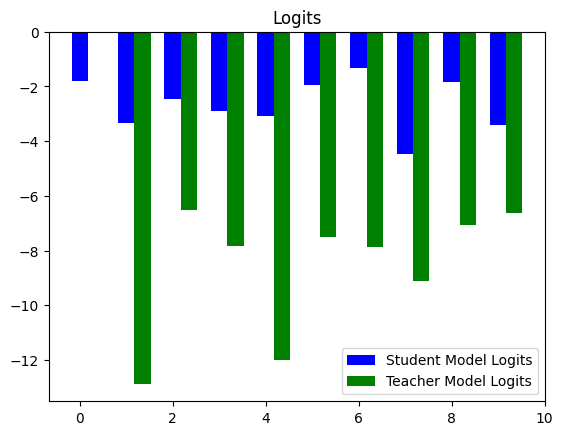

In [76]:
plt.bar(np.arange(10), np.squeeze(output.cpu().numpy()), width=0.35, color='blue', label='Student Model Logits')
plt.bar(np.arange(10)+0.35, np.squeeze(teacher_model_output.cpu().numpy()), width=0.35, color='green', label='Teacher Model Logits')
plt.legend()
plt.title("Logits")
plt.show()

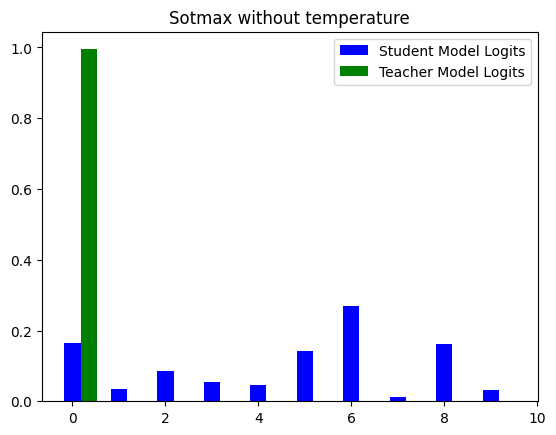

In [77]:
plt.bar(np.arange(10), np.squeeze(torch.softmax(output,dim=1).cpu().numpy()), width=0.35, color='blue', label='Student Model Logits')
plt.bar(np.arange(10)+0.35, np.squeeze(torch.softmax(teacher_model_output,dim=1).cpu().numpy()), width=0.35, color='green', label='Teacher Model Logits')
plt.legend()
plt.title("Sotmax without temperature")
plt.show()

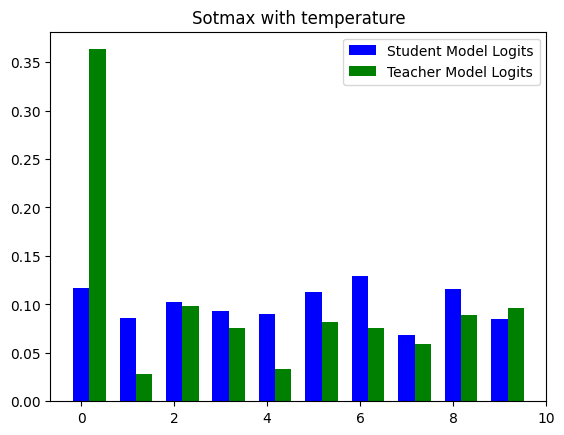

In [78]:
temperature = 5

plt.bar(np.arange(10), np.squeeze(torch.softmax(output/temperature,dim=1).cpu().numpy()), width=0.35, color='blue', label='Student Model Logits')
plt.bar(np.arange(10)+0.35, np.squeeze(torch.softmax(teacher_model_output/temperature,dim=1).cpu().numpy()), width=0.35, color='green', label='Teacher Model Logits')
plt.legend()
plt.title("Sotmax with temperature")
plt.show()